## 1. Преобразование чистых текстовых данных в структурированные (csv-формат)

In [4]:
import os
import re
from datetime import date

from matplotlib import pyplot as plt

In [6]:
# Месяцы в родительном падеже
MONTHS = {
    "января": 1, "февраля": 2, "марта": 3, "апреля": 4, "мая": 5, "июня": 6,
    "июля": 7, "августа": 8, "сентября": 9, "октября": 10, "ноября": 11, "декабря": 12,
}
MONTH_RE = r"(января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)"
DASH_RE = r"[—–-]"  # эм-, эн-, дефис

# Паттерны: сначала «день месяц — день месяц», затем «день—день месяц», затем одиночная дата
PATTERN_CROSS_MONTH = re.compile(
    rf"^(\d{{1,2}})\s+{MONTH_RE}\s*{DASH_RE}\s*(\d{{1,2}})\s+{MONTH_RE}\b",
    re.IGNORECASE,
)
PATTERN_SAME_MONTH_RANGE = re.compile(
    rf"^(\d{{1,2}})\s*{DASH_RE}\s*(\d{{1,2}})\s+{MONTH_RE}\b",
    re.IGNORECASE,
)
PATTERN_SINGLE_DATE = re.compile(
    rf"^(\d{{1,2}})\s+{MONTH_RE}\b",
    re.IGNORECASE,
)


def _month_num(name: str) -> int:
    return MONTHS[name.lower()]


def parse_events_file(source_path: str, out_path: str):
    # Год из имени файла (например, "2001.txt" → "2001")
    m_year = re.search(r"(\d{4})", os.path.basename(source_path))
    if m_year:
        year = int(m_year.group(1))
    else:
        print(f"⚠️ Не удалось распознать год из названия файла: {source_path}")
        return

    with open(source_path, "r", encoding="utf-8") as f:
        text = f.read()

    # По строкам, без пустых
    lines = [line.strip() for line in text.splitlines() if line.strip()]

    data = []
    current_start = None
    current_end = None

    for line in lines:
        # 1) Диапазон с разными месяцами: «25 июля—23 сентября …»
        m = PATTERN_CROSS_MONTH.match(line)
        if m:
            d1, m1, d2, m2 = m.groups()
            y_start = year
            y_end = year
            # если переход через год (например, «декабря—января») — увеличим год конца
            if _month_num(m2) < _month_num(m1) and year:
                # конец в следующем календарном году
                y_end = y_start + 1

            current_start = date(y_start, _month_num(m1), int(d1))
            current_end = date(y_end, _month_num(m2), int(d2))
            event = line[m.end():].lstrip(" \t:—–-—").strip()
            if event:
                data.append((current_start, current_end, event))
            continue

        # 2) Диапазон в одном месяце: «1–30 января …»
        m = PATTERN_SAME_MONTH_RANGE.match(line)
        if m:
            d1, d2, m1 = m.groups()
            current_start = date(int(year), _month_num(m1), int(d1))
            current_end = date(int(year), _month_num(m1), int(d2))
            event = line[m.end():].lstrip(" \t:—–-—").strip()
            if event:
                data.append((current_start, current_end, event))
            continue

        # 3) Одиночная дата: «2 января …» или «2 января:» (без события на той же строке)
        m = PATTERN_SINGLE_DATE.match(line)
        if m:
            d1, m1 = m.groups()
            current_start = date(int(year), _month_num(m1), int(d1))
            current_end = None
            event = line[m.end():].lstrip(" \t:—–-—").strip()
            if event:
                data.append((current_start, current_end or "", event.capitalize()))
            continue

        # 4) Строка-событие под текущей датой/диапазоном
        if current_start:
            data.append((current_start, current_end or "", line))
        else:
            print(f"⚠️ Не удалось распарсить строку: {line}")

    df = pd.DataFrame(data, columns=["date_start", "date_end", "event"])

    df.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"✅ [{year or '—'}] Экспортировано {len(df)} строк → {out_path}")


def parse_raw_events(folder_path: str, out_path: str):
    """
    Обходит все .txt в папке и парсит каждый.
    """
    files = sorted(f for f in os.listdir(folder_path) if f.lower().endswith(".txt"))

    for name in files:
        source_path = os.path.join(folder_path, name)
        csv_name = os.path.splitext(name)[0] + ".csv"
        csv_path = os.path.join(out_path, csv_name)
        parse_events_file(source_path, csv_path)


parse_raw_events("events/1_raw", 'events/2_struct')

✅ [2000] Экспортировано 302 строк → events/2_struct\2000.csv
✅ [2001] Экспортировано 238 строк → events/2_struct\2001.csv
✅ [2002] Экспортировано 482 строк → events/2_struct\2002.csv
✅ [2003] Экспортировано 188 строк → events/2_struct\2003.csv
✅ [2004] Экспортировано 136 строк → events/2_struct\2004.csv
✅ [2005] Экспортировано 183 строк → events/2_struct\2005.csv
✅ [2006] Экспортировано 110 строк → events/2_struct\2006.csv
✅ [2007] Экспортировано 126 строк → events/2_struct\2007.csv
✅ [2008] Экспортировано 146 строк → events/2_struct\2008.csv
✅ [2009] Экспортировано 147 строк → events/2_struct\2009.csv
✅ [2010] Экспортировано 170 строк → events/2_struct\2010.csv
✅ [2011] Экспортировано 289 строк → events/2_struct\2011.csv
✅ [2012] Экспортировано 237 строк → events/2_struct\2012.csv
✅ [2013] Экспортировано 247 строк → events/2_struct\2013.csv
✅ [2014] Экспортировано 287 строк → events/2_struct\2014.csv
✅ [2015] Экспортировано 247 строк → events/2_struct\2015.csv
✅ [2016] Экспортировано 

In [8]:
def combine_csv_files(folder_path: str):
    """
    Объединяет все CSV-файлы в указанной папке в один DataFrame
    и сохраняет результат в новый CSV-файл.
    Имя файла формата "<первый>-<последний>.csv".
    """
    # Получаем список CSV файлов в папке
    files = sorted([
        f for f in os.listdir(folder_path)
        if f.endswith('.csv') and '-' not in f
    ])
    if not files:
        raise FileNotFoundError("В указанной папке нет CSV-файлов.")

    # Имя итогового файла
    first_file = os.path.splitext(files[0])[0]
    last_file = os.path.splitext(files[-1])[0]
    output_name = f"{first_file}-{last_file}.csv"
    output_path = os.path.join(folder_path, output_name)

    # Читаем и объединяем
    dataframes = []
    for file in files:
        path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(path)
            dataframes.append(df)
        except Exception as e:
            print(f"⚠️ Ошибка при чтении {file}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_csv(output_path, index=False, encoding='utf-8-sig')

    return combined_df


df = combine_csv_files('./events/2_struct')
print(f'Размер банка событий: {len(df)}')

Размер банка событий: 5649


## Кластеризация

In [9]:
import re
import pandas as pd
from collections import defaultdict

# === Словарь паттернов ===
COUNTRY_KEYWORDS = {
    "Австралия": [
        r"\bавстрали", r"\bканберр", r"\bсидне", r"\bмельбурн",
    ],
    "Австрия": [
        r"\bавстри", r"\bвена", r"\bзальцбург",
    ],
    "Азербайджан": [
        r"\bазербайджан", r"\bбаку", r"\bнагорн[а-я\-]*\s*карабах[а-я]*\b",
    ],
    "Албания": [
        r"\bалбан", r"\bтиран",
    ],
    "Алжир": [
        r"\bалжир",
    ],
    "Аргентина": [
        r"\bаргентин", r"\bбуэнос",
    ],
    "Армения": [
        r"\bармени", r"\bереван",
    ],
    "Афганистан": [
        r"\bафган", r"\bкабул", r"\bталиб",
    ],
    "Бангладеш": [
        r"\bбангладеш", r"\bдакка",
    ],
    'Беларусь': [
        r'\bбеларус', r'\bбелорус', r'\bлукашенк'
    ],
    "Бельгия": [
        r"\bбельги", r"\bбрюссел",
    ],
    "Болгария": [
        r"\bболгар", r"\bсофи",
    ],
    "Боливия": [
        r"\bболиви",
    ],
    "Босния и Герцеговина": [
        r"\bбосни[а-я]*\s*(и)?\s*герцеговин[а-я]*"
    ],
    "Бразилия": [
        r"\bбразил", r"\bбразилиа", r"\bсан-паул", r"\bсалвадор"
    ],
    "Ватикан": [
        r"\bватикан", r"\bпапа римск\b",
    ],
    'Великобритания': [
        r'\bбритан', r'\bвеликобритан', r'\bлондон', r'\bангли',
    ],
    "Венгрия": [
        r"\bвенгр", r'\bбудапешт',
    ],
    "Венесуэла": [
        r"\bвенесуэл",
    ],
    "Гана": [
        r"\bгана", r"\bаккр",
    ],
    "Гватемала": [
        r"\bгватемал",
    ],
    'Германия': [
        r'\bгерман', r'\bберлин', r'\bкельн',
    ],
    "Греция": [
        r"\bгреци", r"\bафин",
    ],
    "Грузия": [
        r"\bгрузи", r"\bтбилис",
    ],
    "Дания": [
        r"\bдани", r"\bкопенгаген", r'\bдатчане',
    ],
    "Зимбабве": [
        r"\bзимбабв",
    ],
    'Израиль': [
        r'\bизраил', r'\bтель-авив', r'\bиерусалим',
    ],
    "Индонезия": [
        r"\bиндонез", r"\bджакарт",
    ],
    "Ирак": [
        r"\bирак", r"\bбагдад",
    ],
    "Ирландия": [
        r"\bирланд", r"\bдублин",
    ],
    "Испания": [
        r"\bиспани", r"\bмадрид", r"\bбарселон",
    ],
    'Индия': [
        r"\bинд(?:ия|ийск)[а-я]*", r"\bдели", r"\bмумба[и-я]*",
    ],
    'Иран': [
        r'\bиран', r'\bтегеран',
    ],
    "Италия": [
        r"\bитал[а-я]*", r"\bрим", r"\bмилан", r"\bнеапол", r"\bфлоренц", r"\bтурин",
        r"\bвенеци"
    ],
    "Йемен": [
        r"\bйемен", r'\bхусит',
    ],
    "Камбоджа": [
        r"\bкамбодж", r"\bпномпен",
    ],
    "Камерун": [
        r"\bкамерун", r"\bяунд",
    ],
    "Канада": [
        r"\bканад", r"\bоттав", r"\bторонт", r"\bмонреал", r"\bванкувер",
    ],
    "Казахстан": [
        r"\bказахстан", r"\bастан", r"\bалмат", r"\bалма-ат", r"\bкараганд"
    ],
    "Кипр": [
        r"\bкипр[а-я]*", r'\bникос',
    ],
    "Киргизия": [
        r"\bкыргыз", r"\bкиргиз", r"\bбишкек",
    ],
    'Китай': [
        r'\bкита', r'\bпекин', r'си цзиньпин',
    ],
    "Коморы": [
        r"\bкомор", r"\bморони"
    ],
    "Косово": [
        r"\bкосов", r"\bприштин"
    ],
    "Кот-д’Ивуар": [
        r"\bабиджан", r"\bкот(?:[-–—\s]?д['’]?)\s*ивуар[а-я]*",
    ],
    "Латвия": [
        r"\bлатви", r"\bриг[а-я]\b",
    ],
    "Ливан": [
        r"\bливан", r"\bбейрут"
    ],
    "Литва": [
        r"\bлитв", r"\bвильнюс",
    ],
    "Лихтенштейн": [
        r"\bлихтенштейн",
    ],
    "Македония": [
        r"\bмакедон",
    ],
    "Мальдивы": [
        r"\bмальдив",
    ],
    "Мексика": [
        r"\bмексик", r"\bмехико"
    ],
    "Мозамбик": [
        r"\bмозамбик", r"\bмапут",
    ],
    "Молдова": [
        r"\bмолдов", r"\bмолдав", r'\bкишин[её]в'
    ],
    "Нигерия": [
        r"\bнигери", r"\bабудж",
    ],
    "Нидерланды": [
        r"\bнидерланд", r"\bголланд", r"\bамстердам", r"\bроттердам", r"\bгааг",
    ],
    "Пакистан": [
        r"\bпакистан", r"\bисламабад", r"\bкарач", r"\bлахо", r"\bпенджаб"
    ],
    'Палестина': [
        r'\bхамас', r"\bсектор[а-я]*\s+газ[а-я]*\b"
    ],
    "Перу": [
        r"\bперу", r"\bлима",
    ],
    "Польша": [
        r"\bпольш", r"\bваршав",
    ],
    "Португалия": [
        r"\bпортугал", r"\bлиссабон",
    ],
    'Россия': [
        r'\bросси', r'\bрусск', r"\bроссийск.*федерац", r'\bрпц', r'\bмоскв', r'\bмосков', r'\bрф', r'\bчечен',
        r'\bчечн',
        r'\bсанкт-петербур', r'\bпутин', r'\bгазпром', r'\btelegram\b', r'\bссср\b', r'\bхабаровск', r'\bомск',
        r'\bволгоград', r'\bкалининград', r'\bвладикавказ', r'байкал',
        r'астрахан', r'дагестан',
    ],
    "Румыния": [
        r"\bрумын", r"\bбухарест",
    ],
    "Сальвадор": [
        r"\bсальвадор",
    ],
    "Сан-Марино": [
        r"\bсан-марин", r"\bсерравалл"
    ],
    "Северная Корея": [
        r"\bсеверн.*коре", r"\bпхеньян", r'\bкндр\b'
    ],
    "Сенегал": [
        r"\bсенегал", r"\bдакар",
    ],
    "Сербия": [
        r"\bсерб", r"\bбелград",
    ],
    "Сингапур": [
        r"\bсингапур", r'\bsingapore\b'
    ],
    "Сирия": [
        r"\bсири", r"\bдамаск", r"\bалепп",
    ],
    "Словакия": [
        r"\bсловаки", r"\bбратислав",
    ],
    "Словения": [
        r"\bсловен",
    ],
    "Суринам": [
        r"\bсуринам",
    ],
    'США': [
        r'\bсша\b', r'\bамерик', r'\bвашингтон', r'\bбайден', r'\bбуш', r'\bобам\b', r'\bmicrosoft\b',
        r'\baol\b',
        r'\btime warner\b', r'\bapple\b', r'\bgoogle\b', r'\bfacebook\b', r'\byoutube\b', r'\bsony\b', r'\bоон\b'
    ],
    'Таджикистан': [
        r'\bтаджик', r'\bдушанабе'
    ],
    "Таиланд": [
        r"\bтаиланд", r"\bбангкок",
    ],
    "Тайвань": [
        r"\bтайван", r'\bтайбэй'
    ],
    "Туркменистан": [
        r"\bтуркмен", r"\bашхабад",
    ],
    'Турция': [
        r'\bтурци', r'\bэрдоган', r'\bанкар',
    ],
    "Уганда": [
        r"\bуганд",
    ],
    'Узбекистан': [
        r'\bузбек',
    ],
    'Украина': [
        r'украин', r'\bкиев', r'\bзеленск', r'\bдонецк', r'\bлуганск',
    ],
    "Уругвай": [
        r"\bуругва", r'\bмонтевидео',
    ],
    "Финляндия": [
        r"\bфинлян", r"\bхельсинк",
    ],
    'Франция': [
        r'\bфранц', r'\bпариж', r'\bмакрон',
    ],
    'Хорватия': [
        r'\bхорват'
    ],
    "Черногория": [
        r"\bчерногор", r"\bподгориц",
    ],
    "Чехия": [
        r"\bчехи", r"\bпраг",
    ],
    "Чили": [
        r"\bчили", r"\bсантьяг"
    ],
    "Шотландия": [
        r"\bшотланд", r"\bединбург", r"\bглазг",
    ],
    'Щвейцария': [
        r'\bшвейцар', r'\bберн'
    ],
    "Швеция": [
        r"\bшвед", r"\bстокгольм",
    ],
    "Эквадор": [
        r"\bэквадор", r"\bкито",
    ],
    "Эритрея": [
        r"\bэритре[яи]", r"\bасмэр", r"\bмассауа"
    ],
    "Эстония": [
        r"\bэстони", r"\bталлин",
    ],
    "Эфиопия": [
        r"\bэфиоп", r"\bаддис-абеб"
    ],
    "Югославия": [
        r"\bюгослав"
    ],
    "ЮАР": [
        r"\bюар\b", r"\bюжн.*африк"
    ],
    "Южная Корея": [
        r"\bюжн.*коре", r"\bсеул", r"\bпусан",
    ],
    "Япония": [
        r"\bяпон", r"\bтокио", r"\bтокий", r"\bхиросим", r"\bосака",
    ],
    'UNIDENTIFIED': []
}


def detect_countries(text: str, keywords: dict = COUNTRY_KEYWORDS, threshold: int = 1):
    """
    Определяет страну (или несколько) по тексту события.
    threshold — минимальное количество совпадений, чтобы считать страну найденной.
    Возвращает: список стран, отсортированный по убыванию количества совпадений.
    """
    text = text.lower()
    counts = defaultdict(int)

    for country, patterns in keywords.items():
        for pattern in patterns:
            matches = re.findall(pattern, text)
            if matches:
                counts[country] += len(matches)

    if not counts:
        return ['UNIDENTIFIED']

    # Оставляем страны с количеством совпадений >= threshold
    filtered = {c: n for c, n in counts.items() if n >= threshold}
    if not filtered:
        return ['UNIDENTIFIED']

    # Сортируем по числу совпадений
    ranked = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    return [c for c, _ in ranked]


def classify_events(df: pd.DataFrame, text_column: str = 'event'):
    """
    Добавляет колонку 'countries' на основе текстов событий.
    """
    df = df.copy()
    df['countries'] = df[text_column].apply(detect_countries)
    return df


df = classify_events(df)
undefined_mask = df['countries'].apply(lambda x: 'UNIDENTIFIED' in x)
undefined_count = undefined_mask.sum()

print(f'Всего строк: {len(df)}. Кол-во неопознанных строк: {undefined_count}')

# Вернуть только неопознанные строки
unidentified_df = df[undefined_mask].copy()
df.head()  # 1602 неопознанных из 5661 событий

Всего строк: 5649. Кол-во неопознанных строк: 1602


,date_start,date_end,event,countries
0,2000-01-01,NaN,Деноминация белорусского рубля;,[Беларусь]
1,2000-01-01,NaN,"В связи с «проблемой-2000», в Иране объявлен н...",[Иран]
2,2000-01-01,NaN,"Вступление в силу закона в Великобритании, сог...",[Великобритания]
3,2000-01-02,NaN,Крушение украинского сухогруза типа «река-море...,"[Камбоджа, Украина]"
4,2000-01-03,NaN,Обстрел из гранатомёта территории российского ...,"[Ливан, Россия]"
...,...,...,...,...
5644,2025-09-18,NaN,На камчатке зафиксировано землетрясение магнит...,[UNIDENTIFIED]
5645,2025-09-20,NaN,Проведение конкурса песни «интервидение» в мос...,[Россия]
5646,2025-09-23,NaN,Международный уголовный суд представил подтвер...,[UNIDENTIFIED]
5647,2025-09-25,NaN,Парламент Кыргызстана объявил о самороспуске.,[Киргизия]


In [13]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ruslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
from plot_utils import plot_2d
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

def find_optimal_k(X, K: range = range(2, 200), plot_results=True, ):
    inertias = []
    silhouettes = []

    for k in K:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
        inertias.append(model.inertia_)
        score = silhouette_score(X, labels)
        silhouettes.append(score)
        print(f"k={k}: inertia={model.inertia_:.0f}, silhouette={score:.3f}")

    # Визуализация
    if plot_results:
        plot_2d(list(K), inertias, "Количество кластеров (k)", "Inertia", "Метод локтя")
        plot_2d(list(K), silhouettes, "Количество кластеров (k)", "Silhouette Score", "Silhouette")

    best_silhouette = max((s for s in silhouettes if not pd.isna(s)), default=None)
    best_k = K[silhouettes.index(best_silhouette)] if best_silhouette is not None else None
    best_inertia = inertias[K.index(best_k)] if best_k is not None else None
    return {
        "best_k": best_k,
        "best_silhouette": best_silhouette,
        "best_inertia": best_inertia,
        # "inertias": inertias,
        # "silhouettes": silhouettes,
        # "k_values": K,
    }


def test_tfidf_configs(texts, vectorizer_params_list, K=range(2, 50)):
    """
    Перебирает разные конфигурации TfidfVectorizer,
    вызывает find_optimal_k() для каждой и рисует
    два итоговых графика: Inertia и Silhouette Score.
    """
    all_results = []

    for params in vectorizer_params_list:
        print(f"\n🔹 TF-IDF параметры: {params}")

        # 1️⃣ Векторизация текста
        vectorizer = TfidfVectorizer(**params)
        X = vectorizer.fit_transform(texts)

        # 2️⃣ Используем твою функцию find_optimal_k
        res = find_optimal_k(X, K, plot_results=False)
        all_results.append({
            "params": params,
            # "inertias": res["inertias"],
            # "silhouettes": res["silhouettes"],
            # "k_values": list(res["k_values"]),
            "best_k": res["best_k"],
            "best_silhouette": res["best_silhouette"]
        })

    # 3️⃣ Общие графики сравнения
    plt.figure(figsize=(12, 5))

    # --- Inertia ---
    plt.subplot(1, 2, 1)
    for r in all_results:
        plt.plot(r["k_values"], r["inertias"], marker='o', label=str(r["params"]))
    plt.title("Inertia для разных параметров TF-IDF")
    plt.xlabel("Количество кластеров (k)")
    plt.ylabel("Inertia")
    plt.legend()
    plt.grid(True)

    # --- Silhouette ---
    plt.subplot(1, 2, 2)
    for r in all_results:
        plt.plot(r["k_values"], r["silhouettes"], marker='o', label=str(r["params"]))
    plt.title("Silhouette Score для разных параметров TF-IDF")
    plt.xlabel("Количество кластеров (k)")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return all_results


In [11]:
# Пробуем первую попавшуюся модель кластеризации
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=russian_stopwords
)
X = vectorizer.fit_transform(df["event"].str.lower())

k = 186
model = KMeans(n_clusters=k, random_state=42)
df["cluster"] = model.fit_predict(X)

for i in range(k):
    print(f"\n🟢 Кластер {i}")
    examples = df[df["cluster"] == i]["event"].head(10)
    for e in examples:
        print("  -", e)

C:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



🟢 Кластер 0
  - в Алжире (Алжир) прошёл XV Всемирный фестиваль молодёжи и студентов.
  - в Каракасе (Венесуэла) прошёл XVI Всемирный фестиваль молодёжи и студентов.
  - Состоялся международный музыкальный фестиваль live earth с целью привлечения внимания к проблеме глобального потепления.
  - в Душанбе (Таджикистан) состоялся музыкальный фестиваль «Небо Содружества», который объединил молодых эстрадных звёзд из стран СНГ и Грузии.
  - В харькове (украина) открылся 17-й международный музыкальный фестиваль «харьковские ассамблеи»—2010.
  - VII международный фестиваль короткометражного кино и анимации Open Cinema-2011 (Санкт-Петербург, Россия).
  - I международный фестиваль боевых искусств (Астана, Казахстан).
  - XIX Всемирный фестиваль молодёжи и студентов (Сочи, Россия).

🟢 Кластер 1
  - Учёные Великобритании, США и Италии официально объявили о начале опытов по клонированию человека.
  - Парламентские выборы в италии привели к победе крупнейшей итальянской правоцентристской коалиции —

In [23]:
# Находим оптимальное число кластеров у первой попавшейся модели
# find_optimal_k(X, range(2, 200))
# По графику делаю вывод, что с увеличением кол-ва кластеров результаты постепенно улучшаются. Локоть не наблюдается.
# Время выполнения: 12 минут. Лучший результат: k=199: inertia=4495, silhouette=0.042

k=2: inertia=5544, silhouette=0.007
k=3: inertia=5507, silhouette=0.009
k=4: inertia=5477, silhouette=0.011
k=5: inertia=5441, silhouette=0.013
k=6: inertia=5422, silhouette=0.012
k=7: inertia=5402, silhouette=0.015
k=8: inertia=5370, silhouette=0.017
k=9: inertia=5352, silhouette=0.017
k=10: inertia=5338, silhouette=0.018
k=11: inertia=5317, silhouette=0.018
k=12: inertia=5313, silhouette=0.018
k=13: inertia=5300, silhouette=0.019
k=14: inertia=5281, silhouette=0.021
k=15: inertia=5271, silhouette=0.019
k=16: inertia=5266, silhouette=0.018
k=17: inertia=5254, silhouette=0.018
k=18: inertia=5246, silhouette=0.019
k=19: inertia=5233, silhouette=0.020
k=20: inertia=5215, silhouette=0.021
k=21: inertia=5217, silhouette=0.021
k=22: inertia=5204, silhouette=0.021
k=23: inertia=5207, silhouette=0.020
k=24: inertia=5187, silhouette=0.021
k=25: inertia=5168, silhouette=0.021
k=26: inertia=5179, silhouette=0.022
k=27: inertia=5166, silhouette=0.020
k=28: inertia=5153, silhouette=0.022
k=29: ine

{'best_k': 199,
 'best_silhouette': 0.04182573300265779,
 'best_inertia': 4494.875564755088,
 'inertias': [5543.744235064869,
  5506.955629358249,
  5476.561881529552,
  5440.978972156226,
  5422.153720698634,
  5402.293498299356,
  5370.238921392556,
  5351.524058522778,
  5338.256814388384,
  5316.814681648557,
  5313.286653643303,
  5300.270775449218,
  5281.047537718289,
  5270.759728307721,
  5265.609618477664,
  5253.516440763657,
  5246.058269952089,
  5232.824845988003,
  5214.516744982832,
  5216.932558321166,
  5203.6023895352755,
  5206.933714508084,
  5186.693654880284,
  5167.8353965850765,
  5178.560596438058,
  5165.529030520113,
  5152.52287840535,
  5138.196734292815,
  5131.58288553662,
  5125.192941623467,
  5122.484861507483,
  5108.441041829624,
  5105.390543872028,
  5086.816735307696,
  5095.495063659352,
  5077.509608824389,
  5076.440524172422,
  5078.806840746103,
  5057.083800552058,
  5051.951072809354,
  5049.618095007726,
  5042.19404146579,
  5024.1070801


🔹 TF-IDF параметры: {'max_features': 1000}
k=2: inertia=5401, silhouette=0.016
k=3: inertia=5340, silhouette=0.019
k=4: inertia=5285, silhouette=0.022
k=5: inertia=5223, silhouette=0.026
k=6: inertia=5172, silhouette=0.028
k=7: inertia=5140, silhouette=0.029
k=8: inertia=5141, silhouette=0.029
k=9: inertia=5097, silhouette=0.032
k=10: inertia=5046, silhouette=0.031
k=11: inertia=5020, silhouette=0.035
k=12: inertia=5017, silhouette=0.034
k=13: inertia=4993, silhouette=0.037
k=14: inertia=4962, silhouette=0.036
k=15: inertia=4936, silhouette=0.039
k=16: inertia=4915, silhouette=0.038
k=17: inertia=4905, silhouette=0.040
k=18: inertia=4885, silhouette=0.040
k=19: inertia=4874, silhouette=0.039
k=20: inertia=4858, silhouette=0.040
k=21: inertia=4836, silhouette=0.041
k=22: inertia=4827, silhouette=0.040
k=23: inertia=4808, silhouette=0.044
k=24: inertia=4794, silhouette=0.044
k=25: inertia=4786, silhouette=0.043
k=26: inertia=4758, silhouette=0.047
k=27: inertia=4760, silhouette=0.044
k=

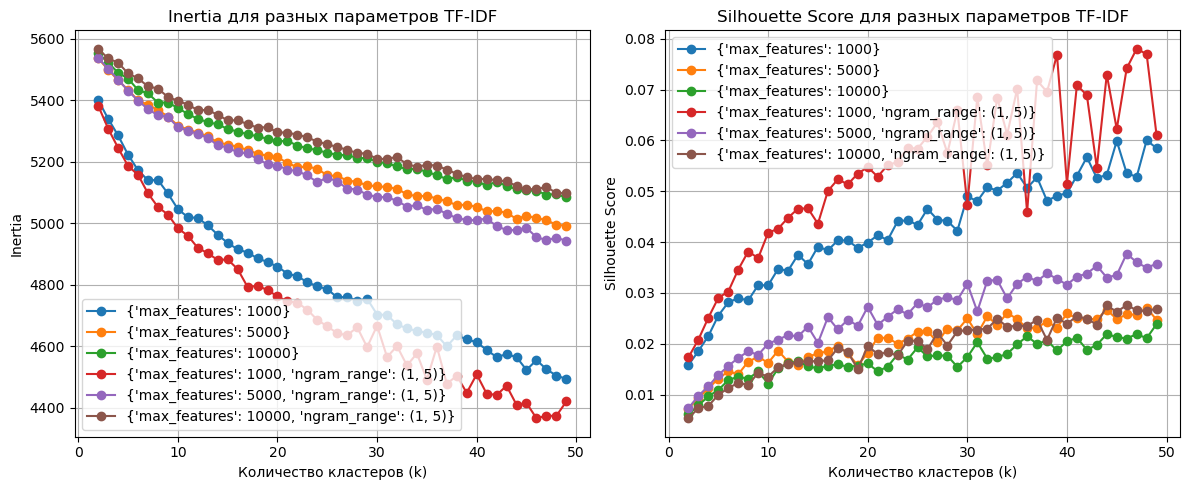

[{'params': {'max_features': 1000},
  'inertias': [5400.716082465907,
   5339.706336950402,
   5285.386836345486,
   5222.614934951872,
   5172.346408321403,
   5139.52013781841,
   5140.551503057667,
   5096.6117341374975,
   5045.830853435382,
   5019.675131953178,
   5016.874262874509,
   4993.26960327183,
   4962.414537237944,
   4935.849207554122,
   4914.9852349266985,
   4904.505820386365,
   4885.433200786287,
   4873.937330566333,
   4858.32749567485,
   4836.227526045629,
   4827.045494664231,
   4808.193611843602,
   4794.451941784227,
   4785.635740388575,
   4758.338673946646,
   4760.254015464475,
   4747.779574570877,
   4754.2203897012205,
   4702.832233436803,
   4701.493290897401,
   4670.642383260035,
   4657.7093067558535,
   4649.370889703634,
   4643.290887349638,
   4636.287231284233,
   4599.189285562993,
   4635.008165497745,
   4622.097320468038,
   4612.551494438796,
   4587.8364378500255,
   4564.284337165425,
   4574.006563520065,
   4564.311343075027,
   4

In [28]:
# Пытаемся определить лучший векторизатор текста путем перебора различных параметров
configs = [
    {"max_features": 1000}, # вариант, хуже дефолтного
    {"max_features": 5000}, # дефолтный вариант
    {"max_features": 10_000}, # улучшенный дефолтный вариант
    {"max_features": 1000, "ngram_range": (1, 5)},
    {"max_features": 5000, "ngram_range": (1, 5)},
    {"max_features": 10000, "ngram_range": (1, 5)},
]

# results = test_tfidf_configs(df["clean_event"], configs, K=range(2, 50))
results
# лучший результат показали n_features=1000 с n-граммами (k=48: inertia=4373, silhouette=0.077). Попробуем найти для него подходящее кол-во кластеров
# время выполнения 7m 28s

k=2: inertia=5339, silhouette=0.020
k=3: inertia=5276, silhouette=0.025
k=4: inertia=5220, silhouette=0.027
k=5: inertia=5158, silhouette=0.032
k=6: inertia=5115, silhouette=0.035
k=7: inertia=5105, silhouette=0.033
k=8: inertia=5044, silhouette=0.038
k=9: inertia=5022, silhouette=0.039
k=10: inertia=4971, silhouette=0.043
k=11: inertia=4956, silhouette=0.042
k=12: inertia=4937, silhouette=0.046
k=13: inertia=4913, silhouette=0.043
k=14: inertia=4861, silhouette=0.048
k=15: inertia=4834, silhouette=0.050
k=16: inertia=4849, silhouette=0.049
k=17: inertia=4816, silhouette=0.051
k=18: inertia=4794, silhouette=0.054
k=19: inertia=4762, silhouette=0.054
k=20: inertia=4757, silhouette=0.052
k=21: inertia=4714, silhouette=0.060
k=22: inertia=4723, silhouette=0.055
k=23: inertia=4704, silhouette=0.055
k=24: inertia=4718, silhouette=0.055
k=25: inertia=4706, silhouette=0.054
k=26: inertia=4648, silhouette=0.061
k=27: inertia=4667, silhouette=0.060
k=28: inertia=4628, silhouette=0.061
k=29: ine

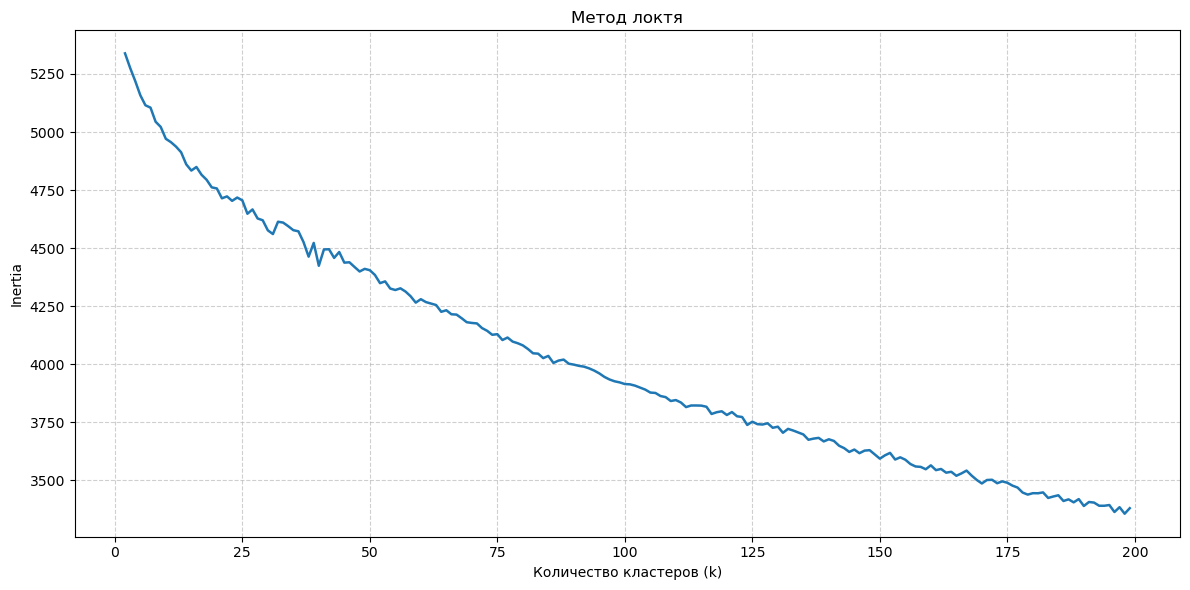

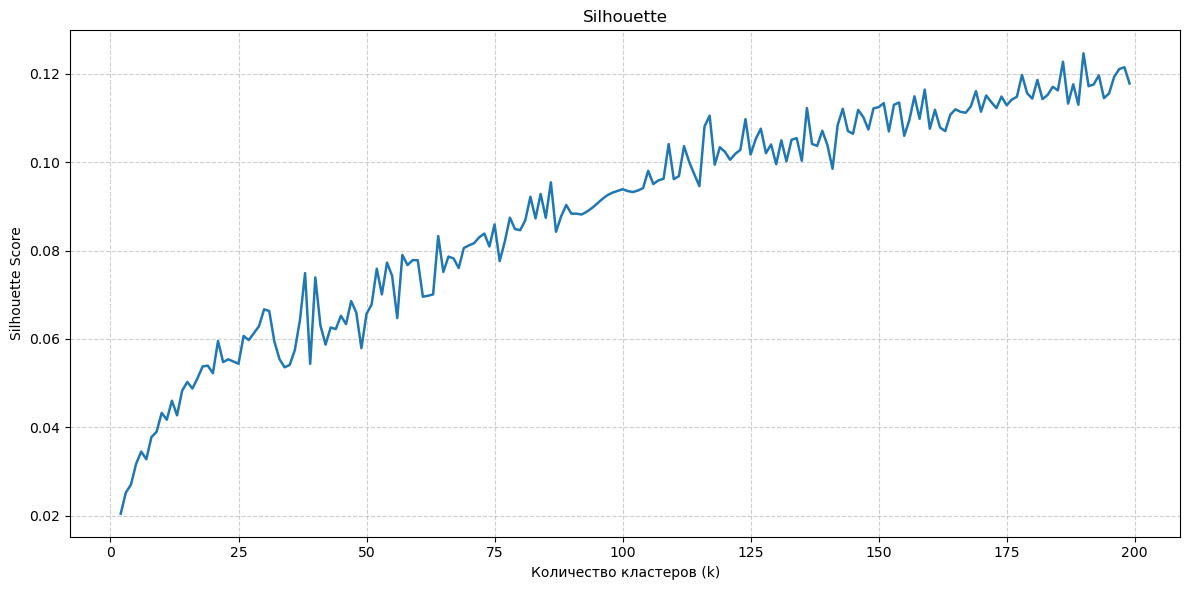

{'best_k': 190,
 'best_silhouette': 0.12463220566561815,
 'best_inertia': 3389.09578628117,
 'inertias': [5338.910963282074,
  5276.464258393119,
  5219.931774867343,
  5158.447989199069,
  5115.233894194667,
  5105.085374939249,
  5044.357480906048,
  5022.017200571824,
  4970.843674418938,
  4956.356583004925,
  4937.169445478192,
  4912.813788802037,
  4861.001433463975,
  4834.033333997605,
  4849.4264132096805,
  4815.988370717072,
  4794.262124502995,
  4761.737269751267,
  4756.933703037581,
  4714.4676299521625,
  4722.694504308615,
  4703.545774297924,
  4717.737759422394,
  4705.772901309708,
  4647.9863969554,
  4666.539270750642,
  4627.569549250017,
  4620.009249247668,
  4576.56974422837,
  4560.4996387436,
  4613.596782831903,
  4609.8830413029145,
  4594.38041674648,
  4577.225521835951,
  4572.245934331023,
  4525.96853096279,
  4463.126540073608,
  4522.378479695348,
  4423.96830455714,
  4494.21186680928,
  4495.075081405752,
  4457.801697047479,
  4483.20521275261,


In [30]:
# мы определили лучший векторизатор, теперь пробуем найти подходящее кол-во кластеров
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 5),
    stop_words=russian_stopwords
)
X = vectorizer.fit_transform(df["event"].str.lower())

# find_optimal_k(X, range(2, 200))
# best k=190: inertia=3389, silhouette=0.125. Время выполнения 6m 28s

In [31]:
# пробуем лучшую модель в действии
k = 190
model = KMeans(n_clusters=k, random_state=42)
df["cluster"] = model.fit_predict(X)

for i in range(k):
    print(f"\n🟢 Кластер {i}")
    examples = df[df["cluster"] == i]["event"].head(10)
    for e in examples:
        print("  -", e)

C:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning




🟢 Кластер 0
  - Приземление космического корабля «Союз ТМ-30». Экипаж посадки — С. В. Залётин, А. Ю. Калери.
  - Приземление космического корабля союз тма-7. экипаж посадки — в. и. токарев, у. макартур (сша) и м. понтис (бразилия).
  - Приземление космического корабля Союз ТМА-8. Экипаж посадки — П. В. Виноградов, Д. Уильямс (США) и А. Ансари (Иран-США).
  - Приземление космического корабля союз тма-9. экипаж посадки — м. в. тюрин, м. лопес-алегриа (испания-сша) и ч. шимоньи (венгрия-сша).
  - Приземление космического корабля союз тма-10. экипаж посадки — ф. н. юрчихин, о. в. котов и шейх музафар шукор (малайзия).
  - Приземление космического корабля союз тма-12. экипаж посадки — с. а. волков, о. д. кононенко и р. гэрриот (сша).
  - Приземление космического корабля союз тма-13 с международным экипажем на борту.
  - приземление космического корабля Союз ТМА-14. Экипаж посадки — Г. И. Падалка, Майкл Баррат (США) и Г. Лалиберте (Канада).
  - приземление космического корабля Союз ТМА-15. 